In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from intervention_utils import intervension
from utils import infix_to_prefix, prepare_batch, check_tolerance, edit_encoder
import time
import omegaconf
from src.nesymres.dclasses import FitParams, BFGSParams
import json
from functools import partial


# try without greedy decoding and with beam search

Lightning automatically upgraded your loaded checkpoint from v1.3.3 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint weights/100M.ckpt`


Running on GPU
['mul', '-1', 'sin', 'x_1']
['mul', '-1', 'sin', 'x_1'] ['mul', '-1', 'sin', 'x_1']


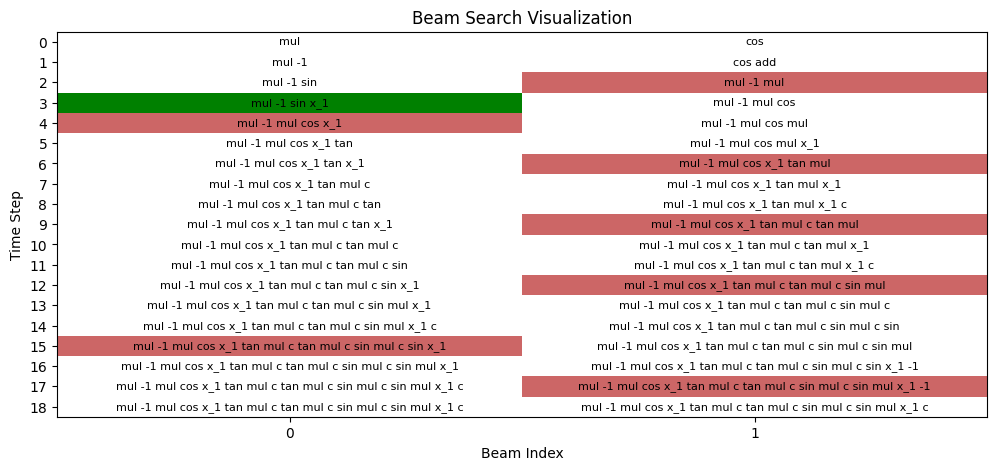

In [13]:
from vis_utils import visualize_beam_search
iclass = intervension()
model = iclass.nnModel

cfg, params_fit = get_params_fit(beam_size=2, max_len=15)

fitfunc = partial(model.fitfunc, cfg_params=params_fit)
symbolic_formula = "(sin(x_1) * -1)"

prefix = infix_to_prefix(symbolic_formula)
target = iclass.encode_ids(prefix)
tol = 0.5

X, y = iclass.get_input(symbolic_formula, n_variables=1, number_of_points=200)

torch.manual_seed(42)
output, generated_history = fitfunc(X, y, enc_input=iclass.Model(X,y))
pred, loss = output["best_bfgs_preds"][0], output["best_bfgs_loss"][0]
prefix_pred = infix_to_prefix(pred)

print(prefix_pred)
visualize_beam_search(generated_history, iclass, prefix_pred, cfg)

Lightning automatically upgraded your loaded checkpoint from v1.3.3 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint weights/100M.ckpt`


Running on GPU
GT:        (sin(x_1) * sin(2)), ['mul', 'sin', 'x_1', 'sin', '2']
Predicted: 0.909297422301601*sin(x_1), ['mul', '0.909297422301601', 'sin', 'x_1']
['mul', 'c', 'sin', 'x_1'] ['mul', '0.909297422301601', 'sin', 'x_1']


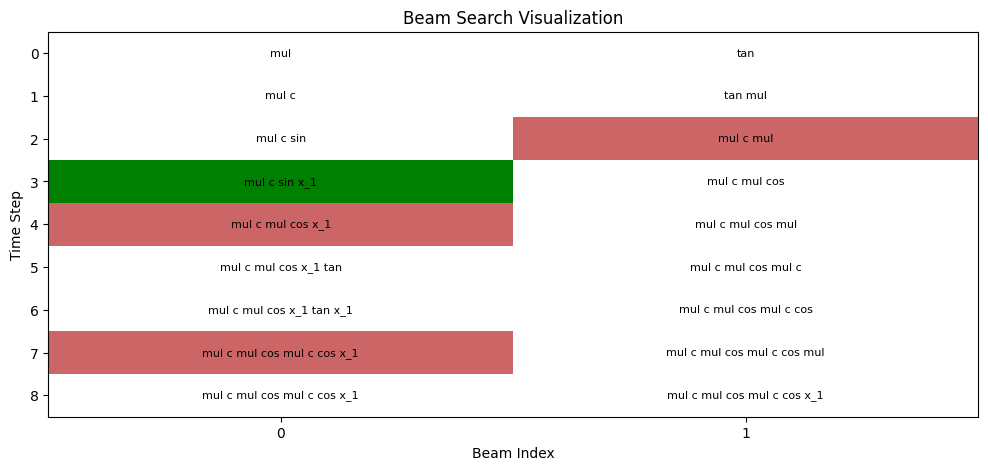

GT:        (x_1 * (exp(x_2) + sin(2))), ['mul', 'x_1', 'add', 'exp', 'x_2', 'sin', '2']
Predicted: x_1*(exp(x_2) + 0.909258836990789), ['mul', 'x_1', 'add', 'exp', 'x_2', '0.909258836990789']


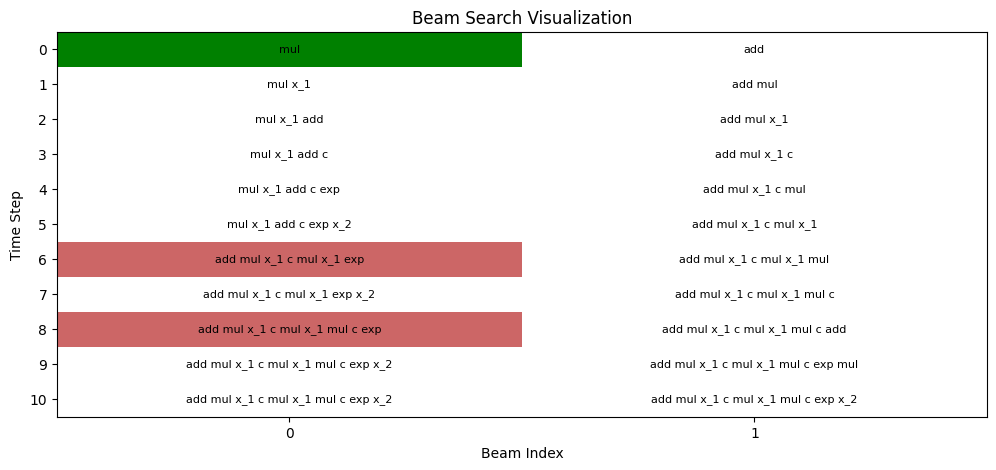

GT:        ((sin(x_1) + x_2) + sin(sin(x_3))), ['add', 'add', 'sin', 'x_1', 'x_2', 'sin', 'sin', 'x_3']
Predicted: ((x_2)+((sin(x_1))+(sin(sin(x_3))))), ['add', 'x_2', 'add', 'sin', 'x_1', 'sin', 'sin', 'x_3']
['add', 'x_2', 'add', 'sin', 'x_1', 'sin', 'sin', 'x_3'] ['add', 'x_2', 'add', 'sin', 'x_1', 'sin', 'sin', 'x_3']


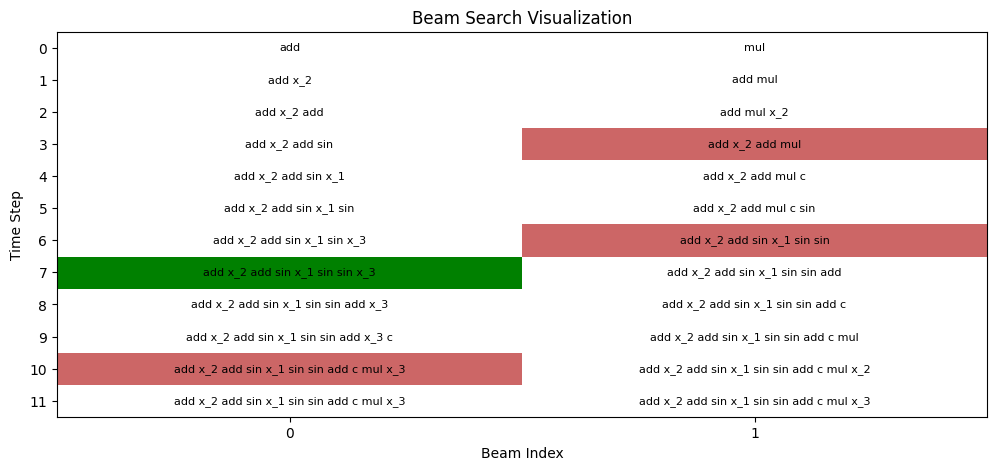

GT:        (sin(x_1) * x_2), ['mul', 'sin', 'x_1', 'x_2']
Predicted: ((x_2)*(sin(x_1))), ['mul', 'x_2', 'sin', 'x_1']
['mul', 'x_2', 'sin', 'x_1'] ['mul', 'x_2', 'sin', 'x_1']


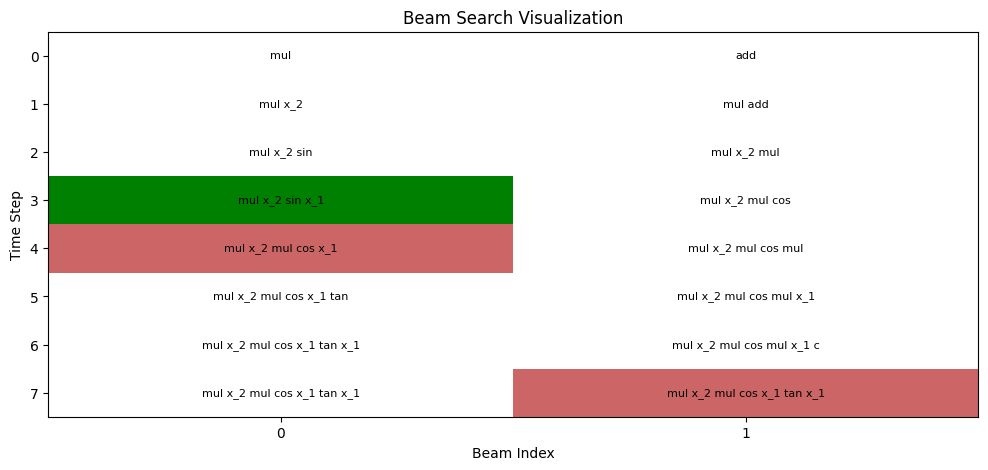

GT:        (sin(x_1) * sin(1)), ['mul', 'sin', 'x_1', 'sin', '1']
Predicted: 0.841470963231974*sin(x_1), ['mul', '0.841470963231974', 'sin', 'x_1']
['mul', 'c', 'sin', 'x_1'] ['mul', '0.841470963231974', 'sin', 'x_1']


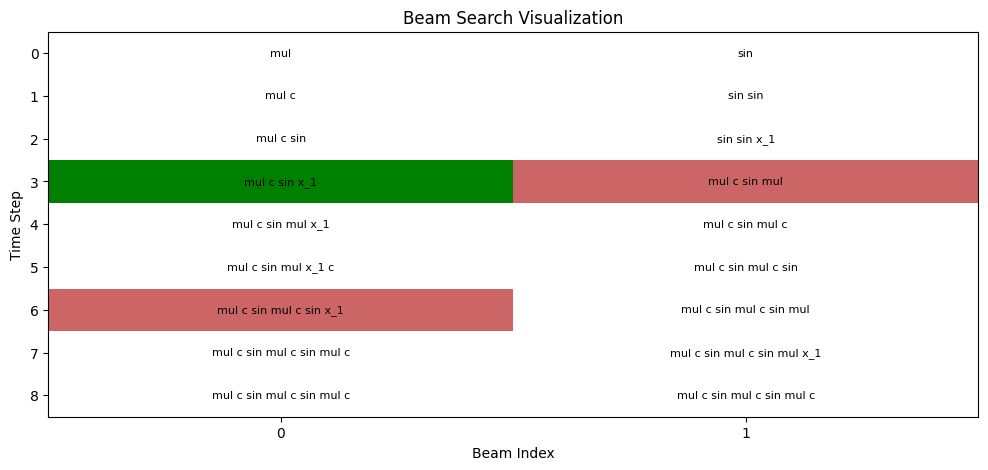

GT:        ((x_1 * (x_2 + x_1)) / sin(4)), ['div', 'mul', 'x_1', 'add', 'x_2', 'x_1', 'sin', '4']
Predicted: -1.32134870016135*x_1*(x_1 + x_2), ['mul', '-1.32134870016135', 'add', 'x_2', 'mul', '2', 'x_1']


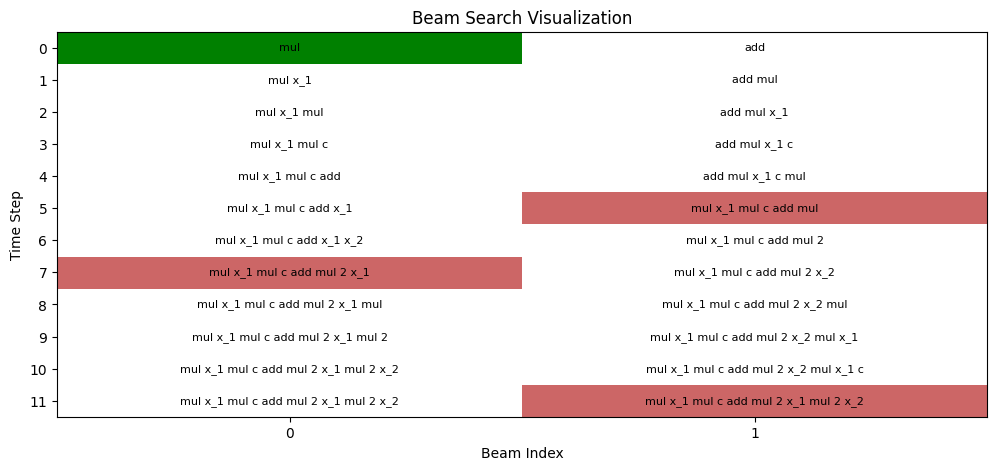

GT:        ((sin(x_1) + x_2) + log((4 * 3))), ['add', 'add', 'sin', 'x_1', 'x_2', 'ln', 'mul', '4', '3']
Predicted: x_2 + sin(x_1) + 2.48490665212418, ['add', 'x_2', 'add', '2.48490665212418', 'sin', 'x_1']
['add', 'x_2', 'add', 'c', 'sin', 'x_1'] ['add', 'x_2', 'add', '2.48490665212418', 'sin', 'x_1']


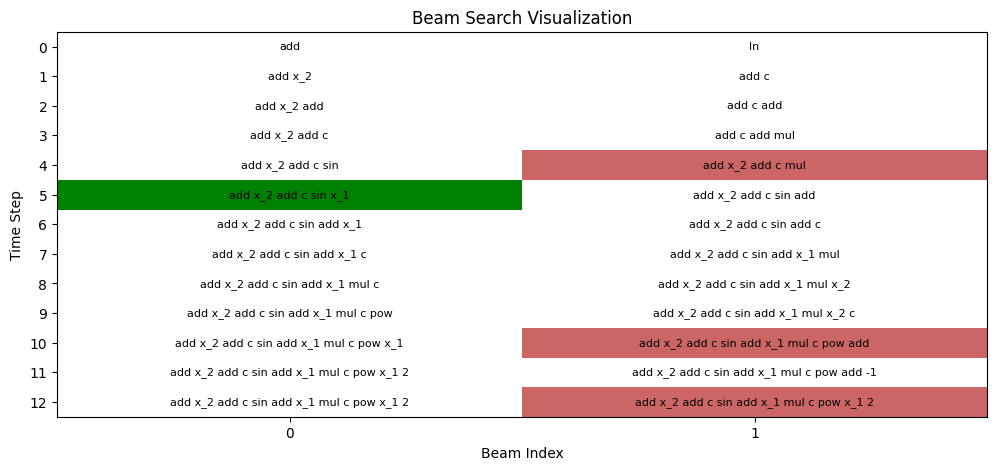

GT:        (sin(x_1) * -1), ['mul', 'sin', 'x_1', '-1']
Predicted: ((-1)*(sin(x_1))), ['mul', '-1', 'sin', 'x_1']
['mul', '-1', 'sin', 'x_1'] ['mul', '-1', 'sin', 'x_1']


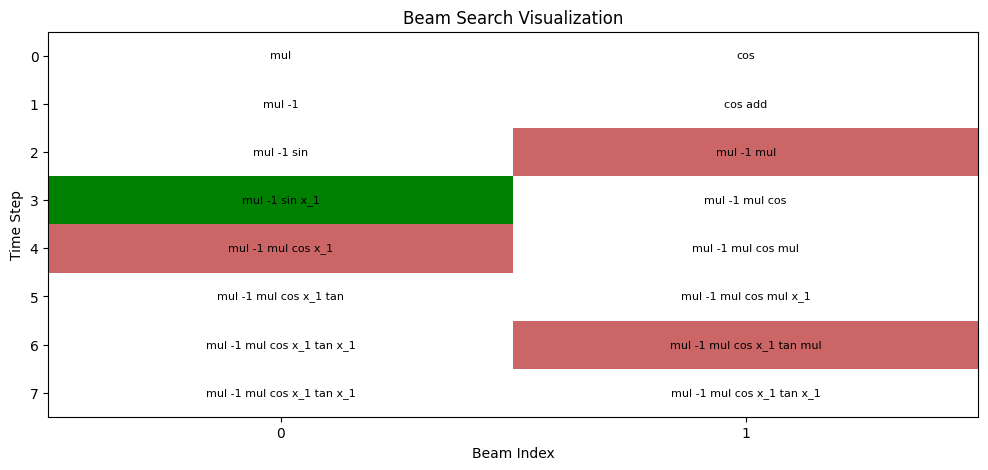

GT:        (x_1 + sin(exp(3))), ['add', 'x_1', 'sin', 'exp', '3']
Predicted: x_1 + 0.944470976818396, ['add', 'x_1', '0.944470976818396']
['add', 'x_1', 'c'] ['add', 'x_1', '0.944470976818396']


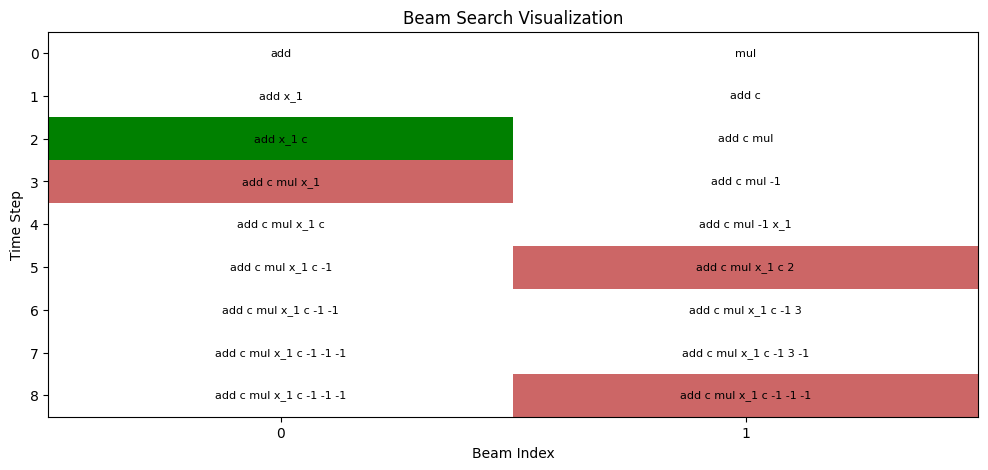

In [26]:
import numpy as np
from vis_utils import visualize_beam_search

dataset = np.load("data/CircuitFinding/dataset_sin_1000.npz", allow_pickle=True)["dataset"]
NUMBER_OF_POINTS=200
iclass = intervension()
model = iclass.nnModel

for i, eq in enumerate(dataset):
    if i >= 9:
        break
    expr_inf, expr_pref, n_vars = eq['expr']['inf'], eq['expr']['pref'], len(eq['expr']['vars'])
    print(f"GT:        {expr_inf}, {expr_pref}")
    cfg, params_fit = get_params_fit(beam_size=2, max_len=len(expr_pref)+5) # MAXLEN!!!
    fitfunc = partial(model.fitfunc, cfg_params=params_fit)
    X, y = iclass.get_input(expr_inf, n_variables=n_vars, number_of_points=NUMBER_OF_POINTS)
    torch.manual_seed(42)
    output, generated_history = fitfunc(X, y, enc_input=iclass.Model(X,y), max_len=len(expr_pref)+5)
    pred, loss = output["best_bfgs_preds"][0], output["best_bfgs_loss"][0]
    prefix_pred = infix_to_prefix(pred)
    print(f"Predicted: {pred}, {prefix_pred}")

    visualize_beam_search(generated_history, iclass, prefix_pred, cfg)
